In [1]:
#import findspark

In [2]:
#findspark.init() # for initialization of SPARK context

In [3]:
#import pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col, isnan, isnull,count,when, mean
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [5]:
spark=SparkSession.builder.getOrCreate() # if there is any existing session it will not create new

### Reading it from VP IP

customer_details = spark.read.csv('hdfs://192.168.232.128:8020/user/cloudera/hackathon/customer_details.csv',header=True)
customer_cdr = spark.read.csv('hdfs://192.168.232.128:8020/user/cloudera/hackathon/customer_cdr.csv',header=True)
plan_details = spark.read.csv('hdfs://192.168.232.128:8020/user/cloudera/hackathon/plan_details.csv',header=True) 

### Either we can create Scema and load the data 

### or else we can load the data then do the type casting of the variables

## Below is an example of how we can create scema

In [17]:
cdrschema = StructType([
   StructField("international_plan",StringType(),True),
   StructField("voice_mail_plan",StringType(),True),
   StructField("pct_call_drops",DoubleType(),True),
   StructField("pct_packet_drops",DoubleType(),True),
   StructField("number_vmail_messages",LongType(),True),
   StructField("total_day_minutes",DoubleType(),True),
   StructField("total_day_calls",LongType(),True),
   StructField("total_eve_minutes",DoubleType(),True),
   StructField("total_eve_calls",LongType(),True),
   StructField("total_night_minutes",DoubleType(),True),
   StructField("tota_night_calls",LongType(),True),
   StructField("total_intl_minutes",DoubleType(),True),
   StructField("total_intl_calls",LongType(),True),
   StructField("phone_number",StringType(),True)])

#create schema for complaint data

complaintschema = StructType([
   StructField("phone_number",StringType(),True),
   StructField("customer_service_calls",LongType(),True),
   StructField("Number_of_complaint_raised",LongType(),True),
   StructField("pct_acket_drops",LongType(),True),
   StructField("Time_for_resolution",LongType(),True),
   StructField("payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account",LongType(),True),
   StructField("Billing_issue",LongType(),True),
   StructField("Calls_are_not_going",LongType(),True),
   StructField("drop_calls",LongType(),True),
   StructField("No_internet_connection",LongType(),True),
   StructField("order",LongType(),True),
   StructField("payment_refund",LongType(),True),
   StructField("recharge_offer_service_fraud",LongType(),True),
   StructField("Slow_network_coverage",LongType(),True)])

#   StructField("uninformed_unsubscribed_weekly_amount_deduct",DoubleType(),True)])
   

#create schema for churn data

churnschema = StructType([
   StructField("churn",StringType(),True),
   StructField("state",StringType(),True),
   StructField("account_length",LongType(),True),
   StructField("area_code",LongType(),True),
   StructField("phone_number",StringType(),True),
   StructField("account_days",LongType(),True),
   StructField("age",LongType(),True),
   StructField("gender",StringType(),True),
   StructField("occupation",StringType(),True),
   StructField("join_date",StringType(),True),
   StructField("subscription_renewal",StringType(),True)])

#create schema for revenue data
revenueschema = StructType([
   StructField("total_day_charge",DoubleType(),True),
   StructField("total_eve_charge",DoubleType(),True),
   StructField("total_night_charge",DoubleType(),True),
   StructField("total_intl_charge",DoubleType(),True),
   StructField("arpu",DoubleType(),True),
   StructField("phone_number",StringType(),True)])

#create schema for signal data
signalschema = StructType([
   StructField("phone_number",StringType(),True),
   StructField("signalstrength_4g",LongType(),True),
   StructField("signalstrength_3g",LongType(),True),
   StructField("Duration_of_good_signal_strength_per",DoubleType(),True),
   StructField("Duration_of_bad_Signal_strength_percent",DoubleType(),True)])

In [18]:
#create dataframe using cdr data
cdr = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\cdr.csv",header=True,schema=cdrschema)
complaint = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\complaint.csv",header=True,schema=complaintschema)
churn = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\customer_churn_demography.csv",header=True,schema=churnschema)
revenue = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\revenue.csv",header=True,schema=revenueschema)
signal = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\signalstrength.csv",header=True,schema=signalschema)

#joining all tables together

h_dff = churn.join(cdr,"phone_number").join(complaint,"phone_number").join(revenue,"phone_number").join(signal,"phone_number")


# Below is example of 
* Normally loading the data
* Do a type casting latter on to change the necesery columns

In [5]:
# now not pandas but SPARK needs to read the files

h_cdr = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\cdr.csv", header = True)
h_complaint = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\complaint.csv", header = True)
h_cust_churn = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\customer_churn_demography.csv", header = True)
h_revenue = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\revenue.csv", header = True)
h_signal = spark.read.csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\signalstrength.csv", header = True)

In [6]:
# Joining al five tables togeather
h_df = (h_cust_churn.join(h_cdr, h_cust_churn["phone number"] == h_cdr["phone number"])
        .join(h_complaint, h_cust_churn["phone number"] == h_complaint["phone number"])
        .join(h_revenue, h_cust_churn["phone number"] == h_revenue["phone number"])
        .join(h_signal, h_cust_churn["phone number"] == h_signal["phone number"]))

In [35]:
h_df.show(1)

+-----+-----+--------------+---------+------------+--------------+---+------+-------------------+------------+------------------------+------------------+---------------+-----------+-------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+------------+------------+----------------------+--------------------------+-------------------+-----------------------------------------------------------------------------+-------------+-------------------+----------+----------------------+-----+--------------+----------------------------+---------------------+-------------------------------------------------+----------------+----------------+------------------+-----------------+-----+------------+------------+-----------------+-----------------+----------------------------------+---------------------------------+
|churn|state|account length|area code|phone number|account (days)|A

### above produced multiple same primary key colum 

" phone number from all the tabels got added to the dataframe"

In [7]:
h_df1 = (h_cust_churn.join(h_cdr, "phone number")
        .join(h_complaint, "phone number")
        .join(h_revenue, "phone number")
        .join(h_signal, "phone number"))

In [9]:
h_df1.show(1)

+------------+-----+-----+--------------+---------+--------------+---+------+-------------------+------------+------------------------+------------------+---------------+-----------+-------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+--------------------------+-------------------+-----------------------------------------------------------------------------+-------------+-------------------+----------+----------------------+-----+--------------+----------------------------+---------------------+-------------------------------------------------+----------------+----------------+------------------+-----------------+-----+-----------------+-----------------+----------------------------------+---------------------------------+
|phone number|churn|state|account length|area code|account (days)|Age|Gender|         Occupation|Joining date|Subscipti

#### Deleting a data column from the first complete dataframe

df.drop('age').collect() # connect() would keep it in the RAM for faster computation . This is not needed now

df.drop(df.age).collect()

In [8]:
# Understanding the feature datatype

h_df1.printSchema()

root
 |-- phone number: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- state: string (nullable = true)
 |-- account length: string (nullable = true)
 |-- area code: string (nullable = true)
 |-- account (days): string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Joining date: string (nullable = true)
 |-- Subsciption renewal date: string (nullable = true)
 |-- international plan: string (nullable = true)
 |-- voice mail plan: string (nullable = true)
 |-- %call drops: string (nullable = true)
 |-- %Packet_drops: string (nullable = true)
 |-- number vmail messages: string (nullable = true)
 |-- total day minutes: string (nullable = true)
 |-- total day calls: string (nullable = true)
 |-- total eve minutes: string (nullable = true)
 |-- total eve calls: string (nullable = true)
 |-- total night minutes: string (nullable = true)
 |-- total night calls: string (nullable = true)

In [12]:
h_df1.count() # to check number of rows

3333

In [13]:
# Checking number of columns and the column names

len(h_df1.columns), h_df1.columns

(46,
 ['phone number',
  'churn',
  'state',
  'account length',
  'area code',
  'account (days)',
  'Age',
  'Gender',
  'Occupation',
  'Joining date',
  'Subsciption renewal date',
  'international plan',
  'voice mail plan',
  '%call drops',
  '%Packet_drops',
  'number vmail messages',
  'total day minutes',
  'total day calls',
  'total eve minutes',
  'total eve calls',
  'total night minutes',
  'total night calls',
  'total intl minutes',
  'total intl calls',
  'customer service calls',
  'Number of complaint raised',
  'Time for resolution',
  'payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account',
  'Billing_issue',
  'Calls_are_not_going',
  'drop_calls',
  'No_internet_connection',
  'order',
  'payment_refund',
  'recharge_offer_service_fraud',
  'Slow_network_coverage',
  'uninformed___unsubscribed_weekly_amount_deduction',
  'total day charge',
  'total eve charge',
  'total night charge',
  'total intl charge',
  'ARPU',
  'signalstrength_4g'

In [14]:
### Summary statistcs
h_df1.describe('churn').show()

+-------+-----+
|summary|churn|
+-------+-----+
|  count| 3333|
|   mean| null|
| stddev| null|
|    min|FALSE|
|    max| TRUE|
+-------+-----+



In [15]:
h_df1.describe('%call drops').show()

+-------+--------------------+
|summary|         %call drops|
+-------+--------------------+
|  count|                3333|
|   mean|0.013547554755475642|
| stddev|0.012994870543239395|
|    min|                   0|
|    max|               0.068|
+-------+--------------------+



### Summary statistics (mean, standard deviance, min ,max , count) of numerical columns in a DataFrame

In [118]:
h_final.summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
phone_number,3333,None,None,327-1058,None,None,None,422-9964
churn,3333,1.0,0.0,1,1,1,1,1
state,3333,None,None,AK,None,None,None,WY
account_length,3333,101.06480648064806,39.82210592859561,1,74,101,127,243
area_code,3333,437.18241824182417,42.371290485606615,408,408,415,510,510
account_days,3333,707.4536453645364,278.75474150016925,7,518,707,889,1701
age,3333,46.198619861986195,16.580956707788236,18,32,46,60,75
gender,3333,None,None,Female,None,None,None,Male
occupation,3333,None,None,Middle Management,None,None,None,student


In [6]:


kk= h_dff.summary().repartition(1) # using summary function to include more statistics as compared to describe()

# we are doing repartition to 1 here as while checking kk.rdd.getNumPartitions() we saw there are 4 partition and needed to join the same

In [7]:
#Saving the file in local drive as CSV
kk.write.save("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\descriptiveStatistics.csv", format="csv", header = True)

# This function cant overwrite existing table and hence create new table everytime

In [19]:
kk.rdd.getNumPartitions() # this function helps to understand the number of data partition SPARK has done 

1

### Subset data into selected columns 


In [20]:
# How to select column(s) from the DataFrame

h_df2= h_df1.select('churn','%call drops')

In [22]:
# Visualization of few columns
h_df2.show(1)

+-----+-----------+
|churn|%call drops|
+-----+-----------+
|FALSE|      0.008|
+-----+-----------+
only showing top 1 row



### Find the number of distinct levels in selected columns and showing them 

In [24]:
#Find the number of distinct levels in selected coluns

h_df1.select('voice mail plan').distinct().count()


2

In [25]:
h_df1.select('total night calls').distinct().count()

120

In [29]:
# showing the number of distinct levels in selected columns

h_df1.select('voice mail plan').distinct().show()

+---------------+
|voice mail plan|
+---------------+
|             no|
|            yes|
+---------------+



#####After counting the number of distinct values for train and test files, we can see the train file has more categories 
#####than test file. Let us check what are the categories for Product_ID, which are in test file but not in train file by 
#####applying subtract operation.We can do the same for all categorical features.

diff_cat_in_train_test=test.select('Product_ID').subtract(train.select('Product_ID'))
diff_cat_in_train_test.distinct().count()# For distict count
Output:
46

### Cross Tabulation of different variables to understand the frequency distribution



In [31]:
# Cross tabulation

h_df1.crosstab('Age', 'churn').show(2)

+---------+-----+----+
|Age_churn|FALSE|TRUE|
+---------+-----+----+
|       45|   55|  12|
|       34|   48|   4|
+---------+-----+----+
only showing top 2 rows



In [39]:
# let's sort it

h_df1.crosstab('Age', 'churn').sort('Age_churn', assending = True).show(2) # 'Age_churn' is in the output table and hence the sorting sriteria should be on the same

+---------+-----+----+
|Age_churn|FALSE|TRUE|
+---------+-----+----+
|       18|   45|   9|
|       19|   49|  13|
+---------+-----+----+
only showing top 2 rows



### Type casting of the data for analysis

this is required as different algorithm does not work on string data and hence need to convert variables into float selectively

In [11]:
from pyspark.sql.types import *
h_final = h_df1.withColumn("account length", h_df1["account length"].cast(FloatType()))\
.withColumn("account (days)", h_df1["account (days)"].cast(FloatType()))\
.withColumn("Age", h_df1["Age"].cast(FloatType()))\
.withColumn("%call drops", h_df1["%call drops"].cast(FloatType()))\
.withColumn("%Packet_drops", h_df1["%Packet_drops"].cast(FloatType()))\
.withColumn("number vmail messages", h_df1["number vmail messages"].cast(FloatType()))\
.withColumn("total day minutes", h_df1["total day minutes"].cast(FloatType()))\
.withColumn("total day calls", h_df1["total day calls"].cast(FloatType()))\
.withColumn("total eve minutes", h_df1["total eve minutes"].cast(FloatType()))\
.withColumn("total eve calls", h_df1["total eve calls"].cast(FloatType()))\
.withColumn("total night minutes", h_df1["total night minutes"].cast(FloatType()))\
.withColumn("total night calls", h_df1["total night calls"].cast(FloatType()))\
.withColumn("total intl minutes", h_df1["total intl minutes"].cast(FloatType()))\
.withColumn("total intl calls", h_df1["total intl calls"].cast(FloatType()))\
.withColumn("customer service calls", h_df1["customer service calls"].cast(FloatType()))\
.withColumn("Number of complaint raised", h_df1["Number of complaint raised"].cast(FloatType()))\
.withColumn("Time for resolution", h_df1["Time for resolution"].cast(FloatType()))\
.withColumn("payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account", h_df1["payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account"].cast(FloatType()))\
.withColumn("Billing_issue", h_df1["Billing_issue"].cast(FloatType()))\
.withColumn("Calls_are_not_going", h_df1["Calls_are_not_going"].cast(FloatType()))\
.withColumn("drop_calls", h_df1["drop_calls"].cast(FloatType()))\
.withColumn("No_internet_connection", h_df1["No_internet_connection"].cast(FloatType()))\
.withColumn("order", h_df1["order"].cast(FloatType()))\
.withColumn("payment_refund", h_df1["payment_refund"].cast(FloatType()))\
.withColumn("recharge_offer_service_fraud", h_df1["recharge_offer_service_fraud"].cast(FloatType()))\
.withColumn("Slow_network_coverage", h_df1["Slow_network_coverage"].cast(FloatType()))\
.withColumn("uninformed___unsubscribed_weekly_amount_deduction", h_df1["uninformed___unsubscribed_weekly_amount_deduction"].cast(FloatType()))\


### Dummy variable creation and variable encoding

* for the example dataset we are going to change the discrete variables with more than 2 labels as dummy 
* variables with 2 labels will be codeded into 0,1

In [19]:
#Coding churn into 0 and 1-- Dependent variable encoding

from pyspark.sql.functions import col, expr, when

new_churn = expr(
    """IF(churn == "False", 0, 1)"""
)
h_final = h_dff.withColumn("churn",new_churn)

In [ ]:
## Need to check how can 

In [20]:
h_final.printSchema()

root
 |-- phone_number: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- account_days: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- join_date: string (nullable = true)
 |-- subscription_renewal: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- pct_call_drops: double (nullable = true)
 |-- pct_packet_drops: double (nullable = true)
 |-- number_vmail_messages: long (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- tota_night_calls: long (nullable = true)
 |-- total_intl_m

In [22]:
#international_plan

int_plan = expr(
    """IF(international_plan == "no", 0, 1)"""
)
df_int_plan = h_final.select("phone_number","international_plan").withColumn("international_plan_c",int_plan).drop("international_plan")
df_int_plan.show(5)




+------------+--------------------+
|phone_number|international_plan_c|
+------------+--------------------+
|    382-4657|                   0|
|    371-7191|                   0|
|    358-1921|                   0|
|    375-9999|                   1|
|    330-6626|                   1|
+------------+--------------------+
only showing top 5 rows



In [23]:
#voice_mail_plan

voice_plan = expr(
    """IF(voice_mail_plan == "no", 0, 1)"""
)

df_voic_plan = h_final.select("phone_number","voice_mail_plan").withColumn("voice_mail_plan_c",voice_plan).drop("voice_mail_plan")
df_voic_plan.show(5)

+------------+-----------------+
|phone_number|voice_mail_plan_c|
+------------+-----------------+
|    382-4657|                1|
|    371-7191|                1|
|    358-1921|                0|
|    375-9999|                0|
|    330-6626|                0|
+------------+-----------------+
only showing top 5 rows



In [26]:
h_final.select('state').distinct().count()

51

In [25]:
h_final.select('state').distinct().show()

+-----+
|state|
+-----+
|   AZ|
|   SC|
|   LA|
|   MN|
|   NJ|
|   DC|
|   OR|
|   VA|
|   RI|
|   WY|
|   KY|
|   NH|
|   MI|
|   NV|
|   WI|
|   ID|
|   CA|
|   NE|
|   CT|
|   MT|
+-----+
only showing top 20 rows



In [24]:
# Dummy Variable creation

#state

categories = h_final.select("state").distinct().rdd.flatMap(lambda x: x).collect() 
exprs = [when(col("state") == category, 1).otherwise(0).alias(category)
         for category in categories] 


df_state = h_final.select("phone_number",*exprs)
df_state.show(5)



+------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|phone_number| AZ| SC| LA| MN| NJ| DC| OR| VA| RI| WY| KY| NH| MI| NV| WI| ID| CA| NE| CT| MT| NC| VT| MD| DE| MO| IL| ME| WA| ND| MS| AL| IN| OH| TN| IA| NM| PA| SD| NY| TX| WV| GA| MA| KS| FL| CO| AK| AR| OK| UT| HI|
+------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|    382-4657|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|    371-7191|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  

### though I have done the dummy I shall not intigrate this in the ABT as the data size is low, and increasing this many label will increase the variance of the data

In [27]:
h_final.select('occupation').distinct().count() # only five label and hence we are considering the same for the ABT

5

In [28]:
#occupation

categories = h_final.select("occupation").distinct().rdd.flatMap(lambda x: x).collect() 
exprs = [when(col("occupation") == category, 1).otherwise(0).alias(category)
         for category in categories] 
df_occu = h_final.select("phone_number",*exprs)
df_occu.show(5)


+------------+-----------------+-------------------+-----------+-------+------+
|phone_number|Middle Management|Senior Professional|Sr Managers|student|Retire|
+------------+-----------------+-------------------+-----------+-------+------+
|    382-4657|                0|                  1|          0|      0|     0|
|    371-7191|                0|                  0|          0|      0|     1|
|    358-1921|                0|                  0|          0|      0|     1|
|    375-9999|                0|                  1|          0|      0|     0|
|    330-6626|                0|                  0|          0|      0|     1|
+------------+-----------------+-------------------+-----------+-------+------+
only showing top 5 rows



In [29]:
#gender

categories = h_final.select("gender").distinct().rdd.flatMap(lambda x: x).collect() 
exprs = [when(col("gender") == category, 1).otherwise(0).alias(category)
         for category in categories] 
df_gender = h_final.select("phone_number",*exprs)
df_gender.show(5)

+------------+------+----+
|phone_number|Female|Male|
+------------+------+----+
|    382-4657|     1|   0|
|    371-7191|     0|   1|
|    358-1921|     0|   1|
|    375-9999|     1|   0|
|    330-6626|     0|   1|
+------------+------+----+
only showing top 5 rows



## Handling Missing value

We are going to look into some option to handle missing data

In [30]:
# First option to deal with missing value is to delete the rows with missing value

# before doing this step assigning the data frame to another name 

h_df = h_final

In [31]:
# What if I want to drop the all rows with null value

# cheking number of missing value in the dataframe

h_df.count() - h_df.dropna().count()

3

In [32]:
# Function to generate number of missing value by column

def count_nulls(df):
    null_counts = []          #make an empty list to hold our results
    for col in df.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        if ctype != 'string': #skip processing string columns for efficiency (can't have nulls)
            nulls = df.where( df[cname].isNull() ).count()
            result = tuple([cname, nulls])  #new tuple, (column name, null count)
            null_counts.append(result)      #put the new tuple in our result list
    return null_counts

In [87]:
null_counts = count_nulls(h_final)

In [88]:
null_counts

[('churn', 0),
 ('account_length', 0),
 ('area_code', 0),
 ('account_days', 0),
 ('age', 0),
 ('pct_call_drops', 0),
 ('number_vmail_messages', 1),
 ('total_day_minutes', 0),
 ('total_day_calls', 0),
 ('total_eve_minutes', 0),
 ('total_eve_calls', 0),
 ('total_night_minutes', 0),
 ('tota_night_calls', 0),
 ('total_intl_minutes', 0),
 ('total_intl_calls', 0),
 ('customer_service_calls', 0),
 ('Number_of_complaint_raised', 0),
 ('pct_acket_drops', 0),
 ('Time_for_resolution', 0),
 ('payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account',
  0),
 ('Billing_issue', 0),
 ('Calls_are_not_going', 0),
 ('drop_calls', 0),
 ('No_internet_connection', 0),
 ('order', 0),
 ('payment_refund', 0),
 ('recharge_offer_service_fraud', 0),
 ('Slow_network_coverage', 0),
 ('total_day_charge', 0),
 ('total_eve_charge', 0),
 ('total_night_charge', 0),
 ('total_intl_charge', 0),
 ('arpu', 0),
 ('signalstrength_4g', 0),
 ('signalstrength_3g', 0),
 ('Duration_of_good_signal_strength_per',

In [35]:
null_counts = pd.DataFrame(count_nulls(h_final))

In [36]:
null_counts

,0,1
0,churn,0
1,account_length,0
2,area_code,0
3,account_days,0
4,age,0
5,pct_call_drops,0
6,pct_packet_drops,2
7,number_vmail_messages,1
8,total_day_minutes,0
9,total_day_calls,0


In [38]:
import spark_df_profiling

In [39]:
#import pandas as pd
import spark_df_profiling
#import numpy as np
#Initializing PySpark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
#Spark Config
#conf = SparkConf().setAppName("sample_app")
#sc = SparkContext(conf=conf)
#sql = SQLContext(sc)
# Loading transaction Data
#sensor_data_df = sql.read.format("com.databricks.spark.csv").option("header", "true").load("E:\spireon\Data\ganga\sensor_data.csv")

report = spark_df_profiling.ProfileReport(h_df)
report.to_file("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\pyspark_churn_data_profiling_v1.html")

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

### Micro average imutation  method based on each class of mean to be imputed for the missing value
### Defining a Window
The first step to windowing is to define the window parameters. We do this by combining three elements: 
    the grouping (partitionBy), the ordering (orderBy) and the range (rowsBetween). The window we define is then assigned 
    to a variable, which we will use to perform computations.

#### there were 2 missing value on "pct_packet_drops"
#### clearing them off

In [59]:
from pyspark.sql import Window
from pyspark.sql.functions import mean

In [60]:
window = Window.partitionBy('gender', 'occupation').orderBy('pct_packet_drops').rowsBetween(-3, 3)

In [61]:
moving_avg = mean(h_final['pct_packet_drops']).over(window)


In [62]:
h_final  =  h_final.withColumn('moving_avg', moving_avg)
#h_final.show(1)

In [63]:
from pyspark.sql.functions import when, col

In [58]:
# Defining function to replace the null values
def replace_null(orig, ma):
    return when(orig.isNull(), ma).otherwise(orig)

In [64]:
# Creating new column 
h_final = h_final.withColumn('imputed_pkt_drop', 
                       replace_null(col('pct_packet_drops'), col('moving_avg')) 
                      )

In [66]:
h_final.where(h_final['pct_packet_drops'].isNull()).show(2)

+------------+-----+-----+--------------+---------+------------+---+------+-------------------+----------+--------------------+------------------+---------------+--------------+----------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+----------------+------------------+----------------+----------------------+--------------------------+---------------+-------------------+-----------------------------------------------------------------------------+-------------+-------------------+----------+----------------------+-----+--------------+----------------------------+---------------------+----------------+----------------+------------------+-----------------+-----+-----------------+-----------------+------------------------------------+---------------------------------------+----------+----------------+
|phone_number|churn|state|account_length|area_code|account_days|age|gender|         occupation| join_date|subscription_r

In [77]:
h_final.drop('imputed_number_vmail_messages')

DataFrame[phone_number: string, churn: int, state: string, account_length: bigint, area_code: bigint, account_days: bigint, age: bigint, gender: string, occupation: string, join_date: string, subscription_renewal: string, international_plan: string, voice_mail_plan: string, pct_call_drops: double, pct_packet_drops: double, number_vmail_messages: bigint, total_day_minutes: double, total_day_calls: bigint, total_eve_minutes: double, total_eve_calls: bigint, total_night_minutes: double, tota_night_calls: bigint, total_intl_minutes: double, total_intl_calls: bigint, customer_service_calls: bigint, Number_of_complaint_raised: bigint, pct_acket_drops: bigint, Time_for_resolution: bigint, payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account: bigint, Billing_issue: bigint, Calls_are_not_going: bigint, drop_calls: bigint, No_internet_connection: bigint, order: bigint, payment_refund: bigint, recharge_offer_service_fraud: bigint, Slow_network_coverage: bigint, total_day_

In [80]:
h_final=h_final.drop('pct_packet_drops','moving_avg') # dropping the old variable


In [101]:
h_final.printSchema()

root
 |-- phone_number: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- account_days: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- join_date: string (nullable = true)
 |-- subscription_renewal: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- pct_call_drops: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- tota_night_calls: long (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- customer_servic

#### One missing on : "number_vmail_messages"
#### clearing them off


In [89]:
window = Window.partitionBy('gender', 'occupation').orderBy('number_vmail_messages').rowsBetween(-3, 3)

In [90]:
moving_avg = mean(h_final['number_vmail_messages']).over(window)

In [91]:
h_final  =  h_final.withColumn('moving_avg', moving_avg)


In [93]:
h_final = h_final.withColumn('imputed_number_vmail_messages', 
                       replace_null(col('number_vmail_messages'), col('moving_avg')) 
                      )

In [96]:
h_final=h_final.drop('number_vmail_messages','moving_avg')

### Now checking if still missing values are there or not

#### as the function "count_nulls" already defined , just need to call the function

In [97]:
null_counts = count_nulls(h_final)
null_counts

[('churn', 0),
 ('account_length', 0),
 ('area_code', 0),
 ('account_days', 0),
 ('age', 0),
 ('pct_call_drops', 0),
 ('total_day_minutes', 0),
 ('total_day_calls', 0),
 ('total_eve_minutes', 0),
 ('total_eve_calls', 0),
 ('total_night_minutes', 0),
 ('tota_night_calls', 0),
 ('total_intl_minutes', 0),
 ('total_intl_calls', 0),
 ('customer_service_calls', 0),
 ('Number_of_complaint_raised', 0),
 ('pct_acket_drops', 0),
 ('Time_for_resolution', 0),
 ('payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account',
  0),
 ('Billing_issue', 0),
 ('Calls_are_not_going', 0),
 ('drop_calls', 0),
 ('No_internet_connection', 0),
 ('order', 0),
 ('payment_refund', 0),
 ('recharge_offer_service_fraud', 0),
 ('Slow_network_coverage', 0),
 ('total_day_charge', 0),
 ('total_eve_charge', 0),
 ('total_night_charge', 0),
 ('total_intl_charge', 0),
 ('arpu', 0),
 ('signalstrength_4g', 0),
 ('signalstrength_3g', 0),
 ('Duration_of_good_signal_strength_per', 0),
 ('Duration_of_bad_Signal_

### Now before going for further analysis let's combine the data with all the dummy variable created 

#### we did not do it earlier as we wanted to do the imputation with fiderent class levels partition
We are not taking state columns dummy into the new dataframe: as it has 51 distinct values and will increase the variance

In [98]:
#Combining all dummy tables

df_cat_comb = h_final.select('phone_number').distinct().join(df_occu,"phone_number").join(df_gender,"phone_number").join(df_int_plan,"phone_number").join(df_voic_plan,"phone_number")


df_final = h_final.join(df_cat_comb,"phone_number")

## VVI- Note: Now I have two tables 
* df_final: where we have dummy integrated . this will be required for linear kind of model : LR, LM, GLM, SVM
* h_final: discrete columns are kept as it is . This would be useful while using tree based models : RF , CART, GBM, XGBoost

## Correlation analysis 

different methonds for correlation

In [99]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

In [100]:
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

### Before running correlation - need to create a subset of the data only with numerical variables.

In [102]:
kk=h_final

### Jeevan to try doing it by a code using data type

In [104]:
import org.apache.spark.sql.types.StringType
import org.apache.spark.sql.functions.col

df.select(kk.schema.fields.flatMap(lambda f : f.dataType match {
  case StringType => Nil
  case _ => col(f.name) :: Nil
}): _*)

SyntaxError: invalid syntax (<ipython-input-104-17c1ba45d9c9>, line 4)

In [ ]:
import sqlContext.implicits._

val df = sc.parallelize(('a' to 'l').map(_.toString) zip (1 to 10)).toDF("c1","c2")

df.schema.fields
    .collect({case x if x.dataType.typeName == "string" => x.name})
    .foldLeft(df)({case(dframe,field) => dframe.drop(field)})

## Program did not work and hence selecting it manually

In [105]:
h_corr = h_final.select('churn',
                        'account_length',
                        'account_days',
                        'age',
                        'pct_call_drops',
                        'total_day_minutes',
                        'total_day_calls',
                        'total_eve_minutes',
                        'total_eve_calls',
                        'total_night_minutes',
                        'tota_night_calls',
                        'total_intl_minutes',
                        'total_intl_calls',
                        'customer_service_calls',
                        'Number_of_complaint_raised',
                        'pct_acket_drops',
                        'Time_for_resolution',
                        'payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account',
                        'Billing_issue',
                        'Calls_are_not_going',
                        'drop_calls',
                        'No_internet_connection',
                        'order',
                        'payment_refund',
                        'recharge_offer_service_fraud',
                        'Slow_network_coverage',
                        'total_day_charge',
                        'total_eve_charge',
                        'total_night_charge',
                        'total_intl_charge',
                        'arpu',
                        'signalstrength_4g')                       


In [106]:
correlation=compute_correlation_matrix(df=h_corr)

In [107]:
correlation # Just to view the dataframe

,churn,account_length,account_days,age,pct_call_drops,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,...,order,payment_refund,recharge_offer_service_fraud,Slow_network_coverage,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,arpu,signalstrength_4g
churn,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_length,NaN,1.000000,1.000000,-0.001876,0.009559,0.006216,0.038470,-0.006757,0.019260,-0.008955,...,-0.003528,0.012851,-0.015130,-0.013703,0.006214,-0.006745,-0.008960,0.009546,0.001454,0.005337
account_days,NaN,1.000000,1.000000,-0.001876,0.009559,0.006216,0.038470,-0.006757,0.019260,-0.008955,...,-0.003528,0.012851,-0.015130,-0.013703,0.006214,-0.006745,-0.008960,0.009546,0.001454,0.005337
age,NaN,-0.001876,-0.001876,1.000000,0.021256,-0.021005,0.005486,0.001088,-0.000717,-0.014815,...,0.015106,-0.007805,-0.025294,0.006880,-0.021009,0.001079,-0.014869,0.028317,-0.019270,0.003726
pct_call_drops,NaN,0.009559,0.009559,0.021256,1.000000,0.118165,0.002364,0.072424,0.018940,0.047415,...,0.044399,0.011830,-0.019573,0.042042,0.118170,0.072406,0.047407,0.034632,0.146664,-0.449489
total_day_minutes,NaN,0.006216,0.006216,-0.021005,0.118165,1.000000,0.006750,0.007043,0.015769,0.004323,...,0.019850,0.004189,-0.005364,0.011404,1.000000,0.007029,0.004300,-0.010092,0.884754,-0.123461
total_day_calls,NaN,0.038470,0.038470,0.005486,0.002364,0.006750,1.000000,-0.021451,0.006462,0.022938,...,0.020836,0.019105,0.007690,-0.007048,0.006753,-0.021449,0.022927,0.021666,0.003673,-0.001490
total_eve_minutes,NaN,-0.006757,-0.006757,0.001088,0.072424,0.007043,-0.021451,1.000000,-0.011430,-0.012584,...,0.001135,-0.000154,0.001160,-0.010797,0.007050,1.000000,-0.012593,-0.011067,0.413143,-0.078868
total_eve_calls,NaN,0.019260,0.019260,-0.000717,0.018940,0.015769,0.006462,-0.011430,1.000000,-0.002093,...,-0.006400,-0.003383,-0.018006,0.013276,0.015769,-0.011423,-0.002056,0.008674,0.009392,-0.001547
total_night_minutes,NaN,-0.008955,-0.008955,-0.014815,0.047415,0.004323,0.022938,-0.012584,-0.002093,1.000000,...,-0.005618,-0.009237,-0.013936,0.001746,0.004324,-0.012592,0.999999,-0.015180,0.214257,-0.029431


### Writing the correlation matrix in to csv


In [108]:
correlation.to_csv("C:\\Users\\inkpathak\\Desktop\\Hackathon\\Data\\descriptiveStatistics\\correlation.csv", header =T)

### to check correlation of any 2 variables

In [109]:
print(h_corr.corr("pct_call_drops","total_day_calls"))

0.002363662508210924


In [116]:
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

from matplotlib import *
%matplotlib inline


In [134]:
h_final.printSchema()

root
 |-- phone_number: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- account_days: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- join_date: string (nullable = true)
 |-- subscription_renewal: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- pct_call_drops: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- tota_night_calls: long (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- customer_servic

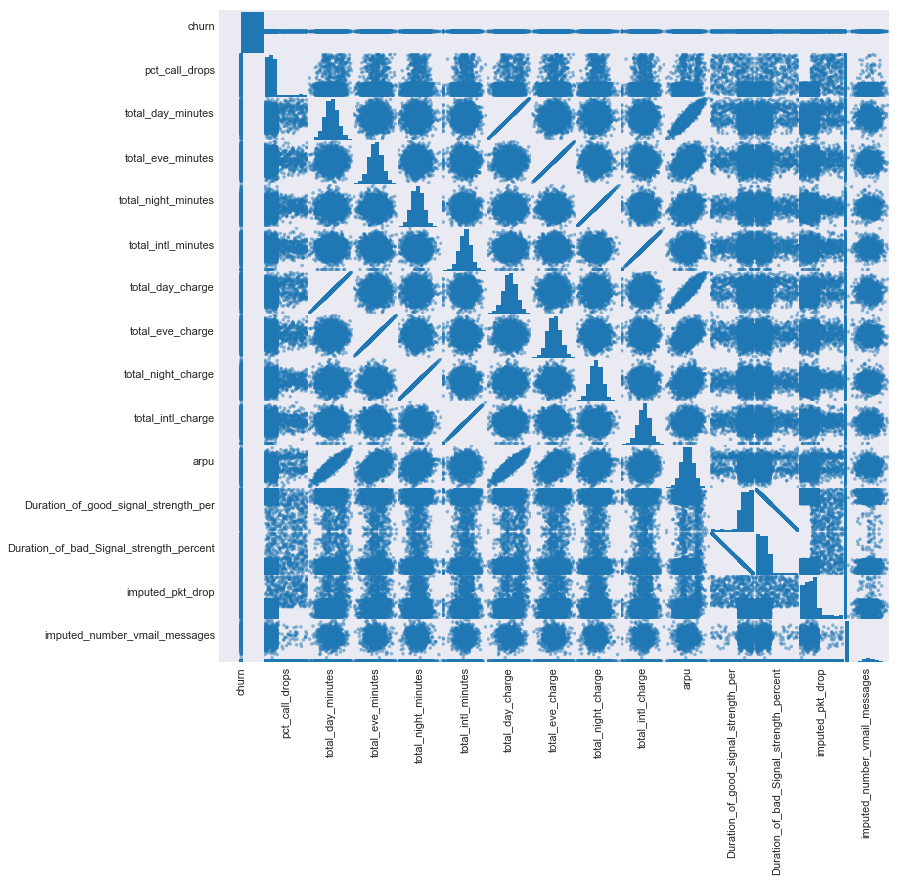

In [117]:
numeric_features = [t[0] for t in h_final.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'float' or t[1] == 'bigint'] # Selecting only numerical colmumns

sampled_data = h_final.select(numeric_features).sample(False, 0.90).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Outlier detection and removal

# Base Model, Model Tuning , Validation

In [119]:
df_final.printSchema()

root
 |-- phone_number: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- account_days: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- join_date: string (nullable = true)
 |-- subscription_renewal: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- pct_call_drops: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- tota_night_calls: long (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- customer_servic

In [127]:
ABT_Tree = h_final.select('churn',
                          'account_length',
                          'account_days',
                          'age',
                          'pct_call_drops',
                          'total_day_minutes',
                          'total_day_calls',
                          'total_eve_minutes',
                          'total_eve_calls',
                          'total_night_minutes',
                          'tota_night_calls',
                          'total_intl_minutes',
                          'total_intl_calls',
                          'customer_service_calls',
                          'Number_of_complaint_raised',
                          'pct_acket_drops',
                          'Time_for_resolution',
                          'Billing_issue',
                          'Calls_are_not_going',
                          'drop_calls',
                          'No_internet_connection',
                          'order',
                          'payment_refund',
                          'recharge_offer_service_fraud',
                          'Slow_network_coverage',
                          'total_day_charge',
                          'total_eve_charge',
                          'total_night_charge',
                          'total_intl_charge',
                          'arpu',
                          'signalstrength_4g') 


In [ ]:
# Another way to crate ABT is with datatype

In [141]:
numeric_featur = [t[0] for t in df_final.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'float' or t[1] == 'bigint'] 

ABT_linear = df_final.select(numeric_featur)

In [149]:
numeric_featur[1:3]

['account_length', 'area_code']

In [169]:
ABT_linear=ABT_linear.drop('area_code','Male')

In [170]:
ABT_linear.printSchema()

root
 |-- churn: integer (nullable = false)
 |-- account_length: long (nullable = true)
 |-- account_days: long (nullable = true)
 |-- age: long (nullable = true)
 |-- pct_call_drops: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- tota_night_calls: long (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- customer_service_calls: long (nullable = true)
 |-- Number_of_complaint_raised: long (nullable = true)
 |-- pct_acket_drops: long (nullable = true)
 |-- Time_for_resolution: long (nullable = true)
 |-- payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account: long (nullable = true)
 |-- Billing_issue: long (nullable = true)
 |-- Calls_are_not_going: long (nullable = true)
 |-- drop

### Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. 
A Pipeline’s stages are specified as an ordered array.

In [150]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.feature import VectorAssembler


In [174]:
stages = [] # stages in our Pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(ABT_linear)
data = pipelineModel.transform(ABT_linear)

In [175]:
cols=ABT_linear.columns

In [176]:
label_stringIdx = StringIndexer(inputCol="churn", outputCol="label")
stages += [label_stringIdx]

In [180]:
assemblerInputs = numeric_featur[3:]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [181]:
assembler.getInputCols()

['account_days',
 'age',
 'pct_call_drops',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'tota_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'customer_service_calls',
 'Number_of_complaint_raised',
 'pct_acket_drops',
 'Time_for_resolution',
 'payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account',
 'Billing_issue',
 'Calls_are_not_going',
 'drop_calls',
 'No_internet_connection',
 'order',
 'payment_refund',
 'recharge_offer_service_fraud',
 'Slow_network_coverage',
 'total_day_charge',
 'total_eve_charge',
 'total_night_charge',
 'total_intl_charge',
 'arpu',
 'signalstrength_4g',
 'signalstrength_3g',
 'Duration_of_good_signal_strength_per',
 'Duration_of_bad_Signal_strength_percent',
 'imputed_pkt_drop',
 'imputed_number_vmail_messages',
 'Middle Management',
 'Senior Professional',
 'Sr Managers',
 'student',
 'Retire',
 'Female',
 'Male',
 'international_plan_c',
 'voice_mail_plan

In [184]:
assembler.getOutputCol()

'features'

In [185]:
selectedcols = ["label", "features"] + cols
data = data.select(selectedcols)

AnalysisException: "cannot resolve '`label`' given input columns: [drop_calls, Calls_are_not_going, student, account_length, total_eve_calls, Female, churn, signalstrength_3g, signalstrength_4g, Senior Professional, pct_acket_drops, arpu, payment_refund, payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account, Slow_network_coverage, Time_for_resolution, imputed_pkt_drop, Duration_of_good_signal_strength_per, Retire, total_day_charge, recharge_offer_service_fraud, pct_call_drops, Sr Managers, total_day_calls, Middle Management, total_night_minutes, total_eve_minutes, imputed_number_vmail_messages, Billing_issue, total_intl_charge, age, tota_night_calls, Duration_of_bad_Signal_strength_percent, customer_service_calls, voice_mail_plan_c, total_intl_minutes, account_days, international_plan_c, order, total_night_charge, No_internet_connection, total_day_minutes, Number_of_complaint_raised, total_eve_charge, total_intl_calls];;\n'Project ['label, 'features, churn#4055, account_length#3864L, account_days#3867L, age#3868L, pct_call_drops#3808, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, Number_of_complaint_raised#3836L, pct_acket_drops#3837L, Time_for_resolution#3838L, payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L, Billing_issue#3840L, Calls_are_not_going#3841L, drop_calls#3842L, No_internet_connection#3843L, ... 23 more fields]\n+- AnalysisBarrier\n      +- Project [churn#4055, account_length#3864L, account_days#3867L, age#3868L, pct_call_drops#3808, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, Number_of_complaint_raised#3836L, pct_acket_drops#3837L, Time_for_resolution#3838L, payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L, Billing_issue#3840L, Calls_are_not_going#3841L, drop_calls#3842L, No_internet_connection#3843L, order#3844L, payment_refund#3845L, ... 21 more fields]\n         +- Project [churn#4055, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, pct_call_drops#3808, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, Number_of_complaint_raised#3836L, pct_acket_drops#3837L, Time_for_resolution#3838L, payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L, Billing_issue#3840L, Calls_are_not_going#3841L, drop_calls#3842L, No_internet_connection#3843L, order#3844L, ... 23 more fields]\n            +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, Number_of_complaint_raised#3836L, ... 31 more fields]\n               +- Join Inner, (phone_number#3866 = phone_number#28490)\n                  :- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, Number_of_complaint_raised#3836L, ... 22 more fields]\n                  :  +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                  :     +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                  :        +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 25 more fields]\n                  :           +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#3869, occupation#3870, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#21661], [gender#3869, occupation#3870], [number_vmail_messages#3810L ASC NULLS FIRST]\n                  :              +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 23 more fields]\n                  :                 +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                  :                    +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 23 more fields]\n                  :                       +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                  :                          +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#3869, occupation#3870, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#17963], [gender#3869, occupation#3870], [number_vmail_messages#3810L ASC NULLS FIRST]\n                  :                             +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 22 more fields]\n                  :                                +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 22 more fields]\n                  :                                   +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 25 more fields]\n                  :                                      +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                         +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 25 more fields]\n                  :                                            +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#3869, occupation#3870, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#17721], [gender#3869, occupation#3870], [number_vmail_messages#3810L ASC NULLS FIRST]\n                  :                                               +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                  :                                                  +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                                     +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                  :                                                        +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                                           +- Window [avg(pct_packet_drops#3809) windowspecdefinition(gender#3869, occupation#3870, pct_packet_drops#3809 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#13781], [gender#3869, occupation#3870], [pct_packet_drops#3809 ASC NULLS FIRST]\n                  :                                                              +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                 +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                  :                                                                    +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                                                       +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#3869, occupation#3870, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10792], [gender#3869, occupation#3870], [number_vmail_messages#3810L ASC NULLS FIRST]\n                  :                                                                          +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                             +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                  :                                                                                +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                                                                   +- Window [avg(pct_packet_drops#3809) windowspecdefinition(gender#3869, occupation#3870, pct_packet_drops#3809 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10500], [gender#3869, occupation#3870], [pct_packet_drops#3809 ASC NULLS FIRST]\n                  :                                                                                      +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                                         +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                  :                                                                                            +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                                                                               +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#3869, occupation#3870, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10208], [gender#3869, occupation#3870], [number_vmail_messages#3810L ASC NULLS FIRST]\n                  :                                                                                                  +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                                                     +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                  :                                                                                                        +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                  :                                                                                                           +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#3869, occupation#3870, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10160], [gender#3869, occupation#3870], [number_vmail_messages#3810L ASC NULLS FIRST]\n                  :                                                                                                              +- Project [phone_number#3866, churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                                                                 +- Project [phone_number#3866, if ((churn#3862 = False)) 0 else 1 AS churn#4055, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                                                                    +- Project [phone_number#3866, churn#3862, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                  :                                                                                                                       +- Join Inner, (phone_number#3866 = phone_number#3896)\n                  :                                                                                                                          :- Project [phone_number#3866, churn#3862, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 18 more fields]\n                  :                                                                                                                          :  +- Join Inner, (phone_number#3866 = phone_number#3889)\n                  :                                                                                                                          :     :- Project [phone_number#3866, churn#3862, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 13 more fields]\n                  :                                                                                                                          :     :  +- Join Inner, (phone_number#3866 = phone_number#3834)\n                  :                                                                                                                          :     :     :- Project [phone_number#3866, churn#3862, state#3863, account_length#3864L, area_code#3865L, account_days#3867L, age#3868L, gender#3869, occupation#3870, join_date#3871, subscription_renewal#3872, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L]\n                  :                                                                                                                          :     :     :  +- Join Inner, (phone_number#3866 = phone_number#3819)\n                  :                                                                                                                          :     :     :     :- Relation[churn#3862,state#3863,account_length#3864L,area_code#3865L,phone_number#3866,account_days#3867L,age#3868L,gender#3869,occupation#3870,join_date#3871,subscription_renewal#3872] csv\n                  :                                                                                                                          :     :     :     +- Relation[international_plan#3806,voice_mail_plan#3807,pct_call_drops#3808,pct_packet_drops#3809,number_vmail_messages#3810L,total_day_minutes#3811,total_day_calls#3812L,total_eve_minutes#3813,total_eve_calls#3814L,total_night_minutes#3815,tota_night_calls#3816L,total_intl_minutes#3817,total_intl_calls#3818L,phone_number#3819] csv\n                  :                                                                                                                          :     :     +- Relation[phone_number#3834,customer_service_calls#3835L,Number_of_complaint_raised#3836L,pct_acket_drops#3837L,Time_for_resolution#3838L,payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L,Billing_issue#3840L,Calls_are_not_going#3841L,drop_calls#3842L,No_internet_connection#3843L,order#3844L,payment_refund#3845L,recharge_offer_service_fraud#3846L,Slow_network_coverage#3847L] csv\n                  :                                                                                                                          :     +- Relation[total_day_charge#3884,total_eve_charge#3885,total_night_charge#3886,total_intl_charge#3887,arpu#3888,phone_number#3889] csv\n                  :                                                                                                                          +- Relation[phone_number#3896,signalstrength_4g#3897L,signalstrength_3g#3898L,Duration_of_good_signal_strength_per#3899,Duration_of_bad_Signal_strength_percent#3900] csv\n                  +- Project [phone_number#28490, Middle Management#4492, Senior Professional#4493, Sr Managers#4494, student#4495, Retire#4496, Female#4537, Male#4538, international_plan_c#4126, voice_mail_plan_c#4148]\n                     +- Join Inner, (phone_number#28490 = phone_number#28469)\n                        :- Project [phone_number#28490, Middle Management#4492, Senior Professional#4493, Sr Managers#4494, student#4495, Retire#4496, Female#4537, Male#4538, international_plan_c#4126]\n                        :  +- Join Inner, (phone_number#28490 = phone_number#28449)\n                        :     :- Project [phone_number#28490, Middle Management#4492, Senior Professional#4493, Sr Managers#4494, student#4495, Retire#4496, Female#4537, Male#4538]\n                        :     :  +- Join Inner, (phone_number#28490 = phone_number#28430)\n                        :     :     :- Project [phone_number#28490, Middle Management#4492, Senior Professional#4493, Sr Managers#4494, student#4495, Retire#4496]\n                        :     :     :  +- Join Inner, (phone_number#28490 = phone_number#28413)\n                        :     :     :     :- Deduplicate [phone_number#28490]\n                        :     :     :     :  +- Project [phone_number#28490]\n                        :     :     :     :     +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, Number_of_complaint_raised#3836L, ... 22 more fields]\n                        :     :     :     :        +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                        :     :     :     :           +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                        :     :     :     :              +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 25 more fields]\n                        :     :     :     :                 +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#28493, occupation#28494, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#21661], [gender#28493, occupation#28494], [number_vmail_messages#3810L ASC NULLS FIRST]\n                        :     :     :     :                    +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 23 more fields]\n                        :     :     :     :                       +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                        :     :     :     :                          +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 23 more fields]\n                        :     :     :     :                             +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 24 more fields]\n                        :     :     :     :                                +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#28493, occupation#28494, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#17963], [gender#28493, occupation#28494], [number_vmail_messages#3810L ASC NULLS FIRST]\n                        :     :     :     :                                   +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 22 more fields]\n                        :     :     :     :                                      +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, customer_service_calls#3835L, ... 22 more fields]\n                        :     :     :     :                                         +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 25 more fields]\n                        :     :     :     :                                            +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                               +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 25 more fields]\n                        :     :     :     :                                                  +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#28493, occupation#28494, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#17721], [gender#28493, occupation#28494], [number_vmail_messages#3810L ASC NULLS FIRST]\n                        :     :     :     :                                                     +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                        :     :     :     :                                                        +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                                           +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                        :     :     :     :                                                              +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                                                 +- Window [avg(pct_packet_drops#3809) windowspecdefinition(gender#28493, occupation#28494, pct_packet_drops#3809 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#13781], [gender#28493, occupation#28494], [pct_packet_drops#3809 ASC NULLS FIRST]\n                        :     :     :     :                                                                    +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                       +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                        :     :     :     :                                                                          +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                                                             +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#28493, occupation#28494, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10792], [gender#28493, occupation#28494], [number_vmail_messages#3810L ASC NULLS FIRST]\n                        :     :     :     :                                                                                +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                                   +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                        :     :     :     :                                                                                      +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                                                                         +- Window [avg(pct_packet_drops#3809) windowspecdefinition(gender#28493, occupation#28494, pct_packet_drops#3809 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10500], [gender#28493, occupation#28494], [pct_packet_drops#3809 ASC NULLS FIRST]\n                        :     :     :     :                                                                                            +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                                               +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                        :     :     :     :                                                                                                  +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                                                                                     +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#28493, occupation#28494, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10208], [gender#28493, occupation#28494], [number_vmail_messages#3810L ASC NULLS FIRST]\n                        :     :     :     :                                                                                                        +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                                                           +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 23 more fields]\n                        :     :     :     :                                                                                                              +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 24 more fields]\n                        :     :     :     :                                                                                                                 +- Window [avg(number_vmail_messages#3810L) windowspecdefinition(gender#28493, occupation#28494, number_vmail_messages#3810L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -3, 3)) AS moving_avg#10160], [gender#28493, occupation#28494], [number_vmail_messages#3810L ASC NULLS FIRST]\n                        :     :     :     :                                                                                                                    +- Project [phone_number#28490, churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                                                                       +- Project [phone_number#28490, if ((churn#28486 = False)) 0 else 1 AS churn#4055, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                                                                          +- Project [phone_number#28490, churn#28486, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :     :                                                                                                                             +- Join Inner, (phone_number#28490 = phone_number#3896)\n                        :     :     :     :                                                                                                                                :- Project [phone_number#28490, churn#28486, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 18 more fields]\n                        :     :     :     :                                                                                                                                :  +- Join Inner, (phone_number#28490 = phone_number#3889)\n                        :     :     :     :                                                                                                                                :     :- Project [phone_number#28490, churn#28486, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 13 more fields]\n                        :     :     :     :                                                                                                                                :     :  +- Join Inner, (phone_number#28490 = phone_number#3834)\n                        :     :     :     :                                                                                                                                :     :     :- Project [phone_number#28490, churn#28486, state#28487, account_length#28488L, area_code#28489L, account_days#28491L, age#28492L, gender#28493, occupation#28494, join_date#28495, subscription_renewal#28496, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L]\n                        :     :     :     :                                                                                                                                :     :     :  +- Join Inner, (phone_number#28490 = phone_number#3819)\n                        :     :     :     :                                                                                                                                :     :     :     :- Relation[churn#28486,state#28487,account_length#28488L,area_code#28489L,phone_number#28490,account_days#28491L,age#28492L,gender#28493,occupation#28494,join_date#28495,subscription_renewal#28496] csv\n                        :     :     :     :                                                                                                                                :     :     :     +- Relation[international_plan#3806,voice_mail_plan#3807,pct_call_drops#3808,pct_packet_drops#3809,number_vmail_messages#3810L,total_day_minutes#3811,total_day_calls#3812L,total_eve_minutes#3813,total_eve_calls#3814L,total_night_minutes#3815,tota_night_calls#3816L,total_intl_minutes#3817,total_intl_calls#3818L,phone_number#3819] csv\n                        :     :     :     :                                                                                                                                :     :     +- Relation[phone_number#3834,customer_service_calls#3835L,Number_of_complaint_raised#3836L,pct_acket_drops#3837L,Time_for_resolution#3838L,payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L,Billing_issue#3840L,Calls_are_not_going#3841L,drop_calls#3842L,No_internet_connection#3843L,order#3844L,payment_refund#3845L,recharge_offer_service_fraud#3846L,Slow_network_coverage#3847L] csv\n                        :     :     :     :                                                                                                                                :     +- Relation[total_day_charge#3884,total_eve_charge#3885,total_night_charge#3886,total_intl_charge#3887,arpu#3888,phone_number#3889] csv\n                        :     :     :     :                                                                                                                                +- Relation[phone_number#3896,signalstrength_4g#3897L,signalstrength_3g#3898L,Duration_of_good_signal_strength_per#3899,Duration_of_bad_Signal_strength_percent#3900] csv\n                        :     :     :     +- Project [phone_number#28413, CASE WHEN (occupation#28417 = Middle Management) THEN 1 ELSE 0 END AS Middle Management#4492, CASE WHEN (occupation#28417 = Senior Professional) THEN 1 ELSE 0 END AS Senior Professional#4493, CASE WHEN (occupation#28417 = Sr Managers) THEN 1 ELSE 0 END AS Sr Managers#4494, CASE WHEN (occupation#28417 = student) THEN 1 ELSE 0 END AS student#4495, CASE WHEN (occupation#28417 = Retire) THEN 1 ELSE 0 END AS Retire#4496]\n                        :     :     :        +- Project [phone_number#28413, if ((churn#28409 = False)) 0 else 1 AS churn#4055, state#28410, account_length#28411L, area_code#28412L, account_days#28414L, age#28415L, gender#28416, occupation#28417, join_date#28418, subscription_renewal#28419, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :           +- Project [phone_number#28413, churn#28409, state#28410, account_length#28411L, area_code#28412L, account_days#28414L, age#28415L, gender#28416, occupation#28417, join_date#28418, subscription_renewal#28419, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :     :              +- Join Inner, (phone_number#28413 = phone_number#3896)\n                        :     :     :                 :- Project [phone_number#28413, churn#28409, state#28410, account_length#28411L, area_code#28412L, account_days#28414L, age#28415L, gender#28416, occupation#28417, join_date#28418, subscription_renewal#28419, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 18 more fields]\n                        :     :     :                 :  +- Join Inner, (phone_number#28413 = phone_number#3889)\n                        :     :     :                 :     :- Project [phone_number#28413, churn#28409, state#28410, account_length#28411L, area_code#28412L, account_days#28414L, age#28415L, gender#28416, occupation#28417, join_date#28418, subscription_renewal#28419, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 13 more fields]\n                        :     :     :                 :     :  +- Join Inner, (phone_number#28413 = phone_number#3834)\n                        :     :     :                 :     :     :- Project [phone_number#28413, churn#28409, state#28410, account_length#28411L, area_code#28412L, account_days#28414L, age#28415L, gender#28416, occupation#28417, join_date#28418, subscription_renewal#28419, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L]\n                        :     :     :                 :     :     :  +- Join Inner, (phone_number#28413 = phone_number#3819)\n                        :     :     :                 :     :     :     :- Relation[churn#28409,state#28410,account_length#28411L,area_code#28412L,phone_number#28413,account_days#28414L,age#28415L,gender#28416,occupation#28417,join_date#28418,subscription_renewal#28419] csv\n                        :     :     :                 :     :     :     +- Relation[international_plan#3806,voice_mail_plan#3807,pct_call_drops#3808,pct_packet_drops#3809,number_vmail_messages#3810L,total_day_minutes#3811,total_day_calls#3812L,total_eve_minutes#3813,total_eve_calls#3814L,total_night_minutes#3815,tota_night_calls#3816L,total_intl_minutes#3817,total_intl_calls#3818L,phone_number#3819] csv\n                        :     :     :                 :     :     +- Relation[phone_number#3834,customer_service_calls#3835L,Number_of_complaint_raised#3836L,pct_acket_drops#3837L,Time_for_resolution#3838L,payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L,Billing_issue#3840L,Calls_are_not_going#3841L,drop_calls#3842L,No_internet_connection#3843L,order#3844L,payment_refund#3845L,recharge_offer_service_fraud#3846L,Slow_network_coverage#3847L] csv\n                        :     :     :                 :     +- Relation[total_day_charge#3884,total_eve_charge#3885,total_night_charge#3886,total_intl_charge#3887,arpu#3888,phone_number#3889] csv\n                        :     :     :                 +- Relation[phone_number#3896,signalstrength_4g#3897L,signalstrength_3g#3898L,Duration_of_good_signal_strength_per#3899,Duration_of_bad_Signal_strength_percent#3900] csv\n                        :     :     +- Project [phone_number#28430, CASE WHEN (gender#28433 = Female) THEN 1 ELSE 0 END AS Female#4537, CASE WHEN (gender#28433 = Male) THEN 1 ELSE 0 END AS Male#4538]\n                        :     :        +- Project [phone_number#28430, if ((churn#28426 = False)) 0 else 1 AS churn#4055, state#28427, account_length#28428L, area_code#28429L, account_days#28431L, age#28432L, gender#28433, occupation#28434, join_date#28435, subscription_renewal#28436, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :           +- Project [phone_number#28430, churn#28426, state#28427, account_length#28428L, area_code#28429L, account_days#28431L, age#28432L, gender#28433, occupation#28434, join_date#28435, subscription_renewal#28436, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :     :              +- Join Inner, (phone_number#28430 = phone_number#3896)\n                        :     :                 :- Project [phone_number#28430, churn#28426, state#28427, account_length#28428L, area_code#28429L, account_days#28431L, age#28432L, gender#28433, occupation#28434, join_date#28435, subscription_renewal#28436, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 18 more fields]\n                        :     :                 :  +- Join Inner, (phone_number#28430 = phone_number#3889)\n                        :     :                 :     :- Project [phone_number#28430, churn#28426, state#28427, account_length#28428L, area_code#28429L, account_days#28431L, age#28432L, gender#28433, occupation#28434, join_date#28435, subscription_renewal#28436, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 13 more fields]\n                        :     :                 :     :  +- Join Inner, (phone_number#28430 = phone_number#3834)\n                        :     :                 :     :     :- Project [phone_number#28430, churn#28426, state#28427, account_length#28428L, area_code#28429L, account_days#28431L, age#28432L, gender#28433, occupation#28434, join_date#28435, subscription_renewal#28436, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L]\n                        :     :                 :     :     :  +- Join Inner, (phone_number#28430 = phone_number#3819)\n                        :     :                 :     :     :     :- Relation[churn#28426,state#28427,account_length#28428L,area_code#28429L,phone_number#28430,account_days#28431L,age#28432L,gender#28433,occupation#28434,join_date#28435,subscription_renewal#28436] csv\n                        :     :                 :     :     :     +- Relation[international_plan#3806,voice_mail_plan#3807,pct_call_drops#3808,pct_packet_drops#3809,number_vmail_messages#3810L,total_day_minutes#3811,total_day_calls#3812L,total_eve_minutes#3813,total_eve_calls#3814L,total_night_minutes#3815,tota_night_calls#3816L,total_intl_minutes#3817,total_intl_calls#3818L,phone_number#3819] csv\n                        :     :                 :     :     +- Relation[phone_number#3834,customer_service_calls#3835L,Number_of_complaint_raised#3836L,pct_acket_drops#3837L,Time_for_resolution#3838L,payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L,Billing_issue#3840L,Calls_are_not_going#3841L,drop_calls#3842L,No_internet_connection#3843L,order#3844L,payment_refund#3845L,recharge_offer_service_fraud#3846L,Slow_network_coverage#3847L] csv\n                        :     :                 :     +- Relation[total_day_charge#3884,total_eve_charge#3885,total_night_charge#3886,total_intl_charge#3887,arpu#3888,phone_number#3889] csv\n                        :     :                 +- Relation[phone_number#3896,signalstrength_4g#3897L,signalstrength_3g#3898L,Duration_of_good_signal_strength_per#3899,Duration_of_bad_Signal_strength_percent#3900] csv\n                        :     +- Project [phone_number#28449, international_plan_c#4126]\n                        :        +- Project [phone_number#28449, international_plan#3806, if ((international_plan#3806 = no)) 0 else 1 AS international_plan_c#4126]\n                        :           +- Project [phone_number#28449, international_plan#3806]\n                        :              +- Project [phone_number#28449, if ((churn#28445 = False)) 0 else 1 AS churn#4055, state#28446, account_length#28447L, area_code#28448L, account_days#28450L, age#28451L, gender#28452, occupation#28453, join_date#28454, subscription_renewal#28455, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :                 +- Project [phone_number#28449, churn#28445, state#28446, account_length#28447L, area_code#28448L, account_days#28450L, age#28451L, gender#28452, occupation#28453, join_date#28454, subscription_renewal#28455, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                        :                    +- Join Inner, (phone_number#28449 = phone_number#3896)\n                        :                       :- Project [phone_number#28449, churn#28445, state#28446, account_length#28447L, area_code#28448L, account_days#28450L, age#28451L, gender#28452, occupation#28453, join_date#28454, subscription_renewal#28455, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 18 more fields]\n                        :                       :  +- Join Inner, (phone_number#28449 = phone_number#3889)\n                        :                       :     :- Project [phone_number#28449, churn#28445, state#28446, account_length#28447L, area_code#28448L, account_days#28450L, age#28451L, gender#28452, occupation#28453, join_date#28454, subscription_renewal#28455, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 13 more fields]\n                        :                       :     :  +- Join Inner, (phone_number#28449 = phone_number#3834)\n                        :                       :     :     :- Project [phone_number#28449, churn#28445, state#28446, account_length#28447L, area_code#28448L, account_days#28450L, age#28451L, gender#28452, occupation#28453, join_date#28454, subscription_renewal#28455, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L]\n                        :                       :     :     :  +- Join Inner, (phone_number#28449 = phone_number#3819)\n                        :                       :     :     :     :- Relation[churn#28445,state#28446,account_length#28447L,area_code#28448L,phone_number#28449,account_days#28450L,age#28451L,gender#28452,occupation#28453,join_date#28454,subscription_renewal#28455] csv\n                        :                       :     :     :     +- Relation[international_plan#3806,voice_mail_plan#3807,pct_call_drops#3808,pct_packet_drops#3809,number_vmail_messages#3810L,total_day_minutes#3811,total_day_calls#3812L,total_eve_minutes#3813,total_eve_calls#3814L,total_night_minutes#3815,tota_night_calls#3816L,total_intl_minutes#3817,total_intl_calls#3818L,phone_number#3819] csv\n                        :                       :     :     +- Relation[phone_number#3834,customer_service_calls#3835L,Number_of_complaint_raised#3836L,pct_acket_drops#3837L,Time_for_resolution#3838L,payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L,Billing_issue#3840L,Calls_are_not_going#3841L,drop_calls#3842L,No_internet_connection#3843L,order#3844L,payment_refund#3845L,recharge_offer_service_fraud#3846L,Slow_network_coverage#3847L] csv\n                        :                       :     +- Relation[total_day_charge#3884,total_eve_charge#3885,total_night_charge#3886,total_intl_charge#3887,arpu#3888,phone_number#3889] csv\n                        :                       +- Relation[phone_number#3896,signalstrength_4g#3897L,signalstrength_3g#3898L,Duration_of_good_signal_strength_per#3899,Duration_of_bad_Signal_strength_percent#3900] csv\n                        +- Project [phone_number#28469, voice_mail_plan_c#4148]\n                           +- Project [phone_number#28469, voice_mail_plan#3807, if ((voice_mail_plan#3807 = no)) 0 else 1 AS voice_mail_plan_c#4148]\n                              +- Project [phone_number#28469, voice_mail_plan#3807]\n                                 +- Project [phone_number#28469, if ((churn#28465 = False)) 0 else 1 AS churn#4055, state#28466, account_length#28467L, area_code#28468L, account_days#28470L, age#28471L, gender#28472, occupation#28473, join_date#28474, subscription_renewal#28475, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                                    +- Project [phone_number#28469, churn#28465, state#28466, account_length#28467L, area_code#28468L, account_days#28470L, age#28471L, gender#28472, occupation#28473, join_date#28474, subscription_renewal#28475, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 22 more fields]\n                                       +- Join Inner, (phone_number#28469 = phone_number#3896)\n                                          :- Project [phone_number#28469, churn#28465, state#28466, account_length#28467L, area_code#28468L, account_days#28470L, age#28471L, gender#28472, occupation#28473, join_date#28474, subscription_renewal#28475, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 18 more fields]\n                                          :  +- Join Inner, (phone_number#28469 = phone_number#3889)\n                                          :     :- Project [phone_number#28469, churn#28465, state#28466, account_length#28467L, area_code#28468L, account_days#28470L, age#28471L, gender#28472, occupation#28473, join_date#28474, subscription_renewal#28475, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L, ... 13 more fields]\n                                          :     :  +- Join Inner, (phone_number#28469 = phone_number#3834)\n                                          :     :     :- Project [phone_number#28469, churn#28465, state#28466, account_length#28467L, area_code#28468L, account_days#28470L, age#28471L, gender#28472, occupation#28473, join_date#28474, subscription_renewal#28475, international_plan#3806, voice_mail_plan#3807, pct_call_drops#3808, pct_packet_drops#3809, number_vmail_messages#3810L, total_day_minutes#3811, total_day_calls#3812L, total_eve_minutes#3813, total_eve_calls#3814L, total_night_minutes#3815, tota_night_calls#3816L, total_intl_minutes#3817, total_intl_calls#3818L]\n                                          :     :     :  +- Join Inner, (phone_number#28469 = phone_number#3819)\n                                          :     :     :     :- Relation[churn#28465,state#28466,account_length#28467L,area_code#28468L,phone_number#28469,account_days#28470L,age#28471L,gender#28472,occupation#28473,join_date#28474,subscription_renewal#28475] csv\n                                          :     :     :     +- Relation[international_plan#3806,voice_mail_plan#3807,pct_call_drops#3808,pct_packet_drops#3809,number_vmail_messages#3810L,total_day_minutes#3811,total_day_calls#3812L,total_eve_minutes#3813,total_eve_calls#3814L,total_night_minutes#3815,tota_night_calls#3816L,total_intl_minutes#3817,total_intl_calls#3818L,phone_number#3819] csv\n                                          :     :     +- Relation[phone_number#3834,customer_service_calls#3835L,Number_of_complaint_raised#3836L,pct_acket_drops#3837L,Time_for_resolution#3838L,payment_made_but_order_not_placed_and_amount_is_deducted_from_my_bank_account#3839L,Billing_issue#3840L,Calls_are_not_going#3841L,drop_calls#3842L,No_internet_connection#3843L,order#3844L,payment_refund#3845L,recharge_offer_service_fraud#3846L,Slow_network_coverage#3847L] csv\n                                          :     +- Relation[total_day_charge#3884,total_eve_charge#3885,total_night_charge#3886,total_intl_charge#3887,arpu#3888,phone_number#3889] csv\n                                          +- Relation[phone_number#3896,signalstrength_4g#3897L,signalstrength_3g#3898L,Duration_of_good_signal_strength_per#3899,Duration_of_bad_Signal_strength_percent#3900] csv\n"